## Prepare environment

In [1]:
!pip install rasterio==1.2.0
!pip install aenum

     |████████████████████████████████| 19.1MB 1.3MB/s 
     |████████████████████████████████| 51kB 4.7MB/s 


In [2]:
!git clone https://github.com/mickerott/tempcnn-example-sentinel2

Cloning into 'tempcnn-example-sentinel2'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29 (delta 8), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [3]:
# add tempcnn-example-sentinel2 to PATH variable
import sys
from pathlib import Path
sys.path.append(str(Path('tempcnn-example-sentinel2').resolve()))

In [4]:
import urllib
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import rasterio

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tempcnn import *
from viz import get_colormap, get_boundarynorm, normalize_img

## Load pre-processed data

In [11]:
input_list = [
              '/content/tempcnn-example-sentinel2/toy_data/B02.tif',
              '/content/tempcnn-example-sentinel2/toy_data/B03.tif',
              '/content/tempcnn-example-sentinel2/toy_data/B04.tif',
              '/content/tempcnn-example-sentinel2/toy_data/B08.tif',
              '/content/tempcnn-example-sentinel2/toy_data/B11.tif',
              '/content/tempcnn-example-sentinel2/toy_data/B12.tif'
              ]
print(input_list)

['/content/tempcnn-example-sentinel2/toy_data/B02.tif', '/content/tempcnn-example-sentinel2/toy_data/B03.tif', '/content/tempcnn-example-sentinel2/toy_data/B04.tif', '/content/tempcnn-example-sentinel2/toy_data/B08.tif', '/content/tempcnn-example-sentinel2/toy_data/B11.tif', '/content/tempcnn-example-sentinel2/toy_data/B12.tif']


In [12]:
def inputs_to_npy(input_list):
    arr = []
    for fp in input_list:
        with rasterio.open(fp) as src:
            a = src.read()
        arr.append(a)
    arr = np.stack(arr, axis=-1)
    return arr

inputs = inputs_to_npy(input_list)
inputs.shape, inputs.dtype

((37, 100, 100, 6), dtype('uint8'))

In [13]:
i=3

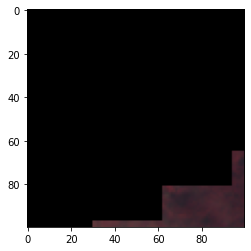

In [14]:
plt.imshow(inputs[i, :, :, [3,2,1]].swapaxes(0,1).swapaxes(1,2)*2)
i+=1

## Get reference data

In [9]:
def get_reference_data(filepath):
    with rasterio.open(labels_path) as src:
        class_labels = src.read().squeeze()
    return class_labels

labels_path = '/content/tempcnn-example-sentinel2/toy_data/labels.tif'
class_labels = get_reference_data(filepath=labels_path)
class_labels.shape

(100, 100)

[ 162 1444 2552 4046  732    0    0    0 1064]


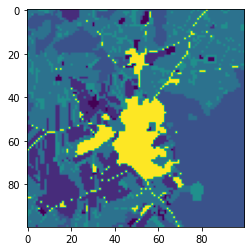

In [10]:
print(np.bincount(class_labels.flatten()))
plt.imshow(class_labels)

## Build tempcnn and fit

### Prepare labels

In [16]:
y = class_labels.flatten()

# remove NoData samples 
valid_indices = np.where(y!=0)
y = y[valid_indices]
np.bincount(y.flatten().astype('int'))

# encoding of labels
classes = list(set(list(y)))
n_classes = len(classes)
le = LabelEncoder()
le.fit(classes)
y = le.transform(y)

# one-hot encoding of labels
y = to_categorical(y, len(list(set(list(y)))))
y.shape

(9838, 5)

### Prepare EO data

In [17]:
shp = inputs.shape
X = inputs.reshape(shp[0], shp[1]*shp[2], shp[3]).swapaxes(0,1)

# remove NoData samples 
X = X[valid_indices]

X.shape

(9838, 37, 6)

### Split into train and test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=np.argmax(y, axis=1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7378, 37, 6), (2460, 37, 6), (7378, 5), (2460, 5))

### Build model with tf.keras

In [19]:
# get lower and upper percentile for normalization
shp = X_train.shape
percentiles = np.nanpercentile(X_train.reshape(shp[0]*shp[1], shp[2]), [2, 98], axis=0).round(3).astype('float32')
min_percentile = percentiles[0, :][np.newaxis, np.newaxis, :]
max_percentile = percentiles[1, :][np.newaxis, np.newaxis, :]
print(min_percentile, max_percentile)

[[[0. 0. 0. 0. 0. 0.]]] [[[37. 34. 37. 92. 77. 56.]]]


In [20]:
# keras normalization layer
class Normalization(tf.keras.layers.Layer):
    def __init__(self):
        super(Normalization, self).__init__(dtype='float32')
        self.min_per = min_percentile
        self.max_per = max_percentile

    def call(self, x, training=False):
        x = ((x-self.min_per) / (self.max_per-self.min_per))
        x = tf.cast(x, dtype='float32')
        x = tf.clip_by_value(x, clip_value_min=0, clip_value_max=1)

        return x

def Archi_NORM_3CONV64_1FC256(X, nbclasses):

    #-- get the input sizes
    m, L, depth = X.shape
    input_shape = (L,depth)

    #-- parameters of the architecture
    l2_rate = 1.e-6
    dropout_rate = 0.5
    nb_conv = 3
    nb_fc= 1
    nbunits_conv = 64 #-- will be double
    nbunits_fc = 256 #-- will be double

    # Define the input placeholder.
    X_input = Input(input_shape)
    X = X_input

    # preprocess
    X = Normalization()(X)

    #-- nb_conv CONV layers
    X = X_input
    for add in range(nb_conv):
        X = conv_bn_relu_drop(X, nbunits=nbunits_conv, kernel_size=5, kernel_regularizer=l2(l2_rate), dropout_rate=dropout_rate)
    #-- Flatten + 	1 FC layers
    X = Flatten()(X)
    for add in range(nb_fc):	
        X = fc_bn_relu_drop(X, nbunits=nbunits_fc, kernel_regularizer=l2(l2_rate), dropout_rate=dropout_rate)
      
    #-- SOFTMAX layer
    out = softmax(X, nbclasses, kernel_regularizer=l2(l2_rate))
      
    # Create model.
    return Model(inputs = X_input, outputs = out, name='Archi_NORM_3CONV64_1FC256')

### Train TempCNN model

In [21]:
# training parameters
lr = 0.001
n_epochs = 10

In [22]:
model = Archi_NORM_3CONV64_1FC256(X, nbclasses=n_classes)
model.compile(optimizer=optimizers.Adam(lr), loss='categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_split=0.25)

Epoch 1/10
173/173 [==============================] - 6s 28ms/step - loss: 1.1738 - accuracy: 0.5760 - val_loss: 1.2887 - val_accuracy: 0.6341
Epoch 2/10
173/173 [==============================] - 4s 25ms/step - loss: 0.7950 - accuracy: 0.7111 - val_loss: 0.5706 - val_accuracy: 0.7837
Epoch 3/10
173/173 [==============================] - 4s 24ms/step - loss: 0.7227 - accuracy: 0.7275 - val_loss: 0.5636 - val_accuracy: 0.7875
Epoch 4/10
173/173 [==============================] - 4s 24ms/step - loss: 0.6784 - accuracy: 0.7452 - val_loss: 0.5600 - val_accuracy: 0.7799
Epoch 5/10
173/173 [==============================] - 4s 24ms/step - loss: 0.6557 - accuracy: 0.7565 - val_loss: 0.5771 - val_accuracy: 0.7827
Epoch 6/10
173/173 [==============================] - 4s 25ms/step - loss: 0.5998 - accuracy: 0.7739 - val_loss: 0.5666 - val_accuracy: 0.7799
Epoch 7/10
173/173 [==============================] - 4s 25ms/step - loss: 0.6150 - accuracy: 0.7647 - val_loss: 0.5562 - val_accuracy: 0.7767

### Evaluate model on test set

In [28]:
proba = model.predict(X_test)

y_test_original = le.inverse_transform(np.argmax(y_test, axis=-1))
pred_original = le.inverse_transform(np.argmax(proba, axis=-1))

cm = confusion_matrix(y_test_original, pred_original)
print(cm)

[[306   0  43   3   9]
 [  2 603  17  15   1]
 [120  34 796  47  15]
 [  3  49  69  62   0]
 [ 28   4  41   6 187]]


## Predict map

In [29]:
%%time
shp = inputs.shape
X_all = inputs.reshape(shp[0], shp[1]*shp[2], shp[3])
X_all = X_all.swapaxes(0,1)

proba = model.predict(X_all)
pred_flat = le.inverse_transform(np.argmax(proba, axis=-1))
pred = pred_flat.reshape(shp[1], shp[2])
pred.shape

CPU times: user 1.68 s, sys: 168 ms, total: 1.84 s
Wall time: 1.23 s


## Visualize result

In [31]:
lulc_cmap = get_colormap()
lulc_norm = get_boundarynorm()

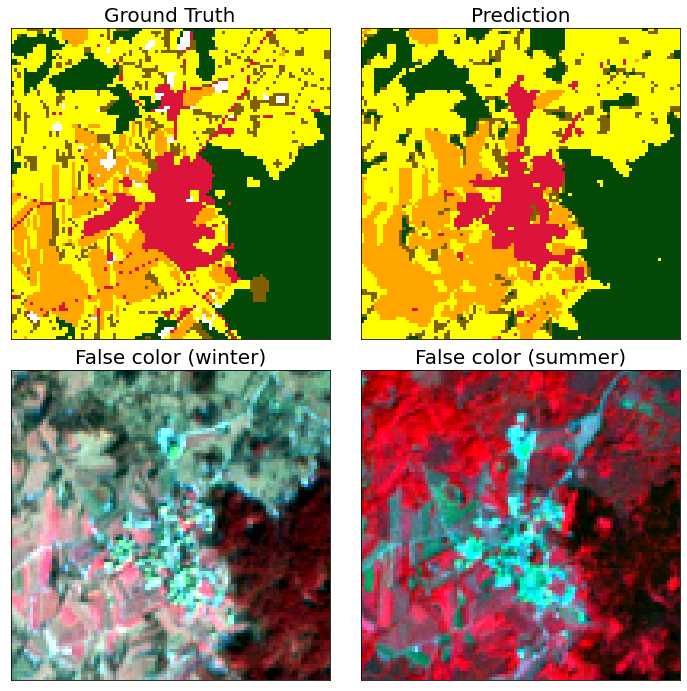

In [32]:
fig = plt.figure(figsize=(12, 12))

ax = plt.subplot(2, 2, 1)
plt.imshow(class_labels, cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Ground Truth', fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(pred, cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title('Prediction', fontsize=20)

ax = plt.subplot(2, 2, 3)
img = inputs[3, ..., [3,2,1]].swapaxes(0,1).swapaxes(1,2)
img = normalize_img(img)
plt.imshow(img)
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('False color (winter)', fontsize=20)

ax = plt.subplot(2, 2, 4)
img = inputs[16, ..., [3,2,1]].swapaxes(0,1).swapaxes(1,2)
img = normalize_img(img)
plt.imshow(img)
plt.xticks([])
plt.yticks([]);
ax.set_aspect("auto")
plt.title('False color (summer)', fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)